# Focus sui Vettori di Embeddings

### Analisi semplificata della similarità tra frasi nello Spazio Latente dei modelli di linguaggio

In [1]:
import numpy as np                                          # pip install numpy
from sklearn.metrics.pairwise import cosine_similarity      # pip install scikit-learn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt                             # pip install matplotlib
from transformers import BertTokenizer, BertModel           # pip install transformers
import torch                                                # https://pytorch.org/get-started/locally/

c:\Users\vinor\Desktop\Develhope\projects\EDU-LLMs_intro\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## BERT
#### (Bidirectional Encoder Representations from Transformers)

BERT è un modello di linguaggio basato su una rete di Transformer sviluppato da Google, progettato per comprendere il contesto di una parola in un testo analizzando simultaneamente le parole a sinistra e a destra di essa (approccio bidirezionale).    
Addestrato su grandi quantità di testo non supervisionato, BERT è particolarmente efficace nei compiti di elaborazione del linguaggio naturale come il **riconoscimento di entità**, l'**analisi del sentiment** e le **risposte a domande**.    
Il suo addestramento prevede due task principali: 
* **masked language modeling** (dove alcune parole vengono nascoste e il modello deve predirle)
* **next sentence prediction** (dove il modello impara le relazioni tra frasi consecutive).

In [5]:
# Funzione per creare vettorio di embeddings usando BERT
def create_embeddings(sentences):
    # carichiamo il tokenizer e un modello pre-addestrato BERT
    tokenizer = BertTokenizer.from_pretrained('ArchitRastogi/bert-base-italian-embeddings')
    model = BertModel.from_pretrained('ArchitRastogi/bert-base-italian-embeddings')
    
    # impostiamo il modello in modalità di valutazione (inferenza)
    model.eval()

    # tokenizzazione delle frasi e creazione dei tensori per BERT
    with torch.no_grad():  # Disabilita il calcolo del gradiente per velocizzare
        encoded_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
        outputs = model(**encoded_inputs)
    
    # prendiamo gli embeddings dalla rappresentazione nascosta di BERT (ultimo layer)
    # outputs.last_hidden_state ha forma (batch_size, sequence_length, hidden_size)
    # applichiamo la media su sequence_length per ottenere un singolo vettore per ogni frase
    sentence_embeddings = torch.mean(outputs.last_hidden_state, dim=1)

    # convertiamo i tensori in numpy array per utilizzarli successivamente
    return sentence_embeddings.numpy()

In [11]:
def plot_embeddings(embeddings, sentences, elev=30, azim=55):
    # applicazione della PCA per ridurre la dimensionalità 
    # dei vettori di embeddings a 3
    pca = PCA(n_components=3)
    embeddings_3d = pca.fit_transform(embeddings)

    # creazione di due subplot per la visualizzazione 3D
    fig = plt.figure(figsize=(15, 6))
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2])
    for i, sentence in enumerate(sentences):
        ax1.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], sentence)
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    
    plt.title('Visualizzazione degli Embeddings (PCA)')
    
    # rotazione della vista
    ax1.view_init(elev=elev, azim=azim)

    # altro subplot 3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2])
    for i, sentence in enumerate(sentences):
        ax2.text(embeddings_3d[i, 0], embeddings_3d[i, 1], embeddings_3d[i, 2], sentence)
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('PC3')
    
    ax2.view_init(elev=elev * 3, azim=azim * 3)

    plt.tight_layout()
    plt.show()

Creazione degli embeddings...

Visualizzazione degli embeddings...


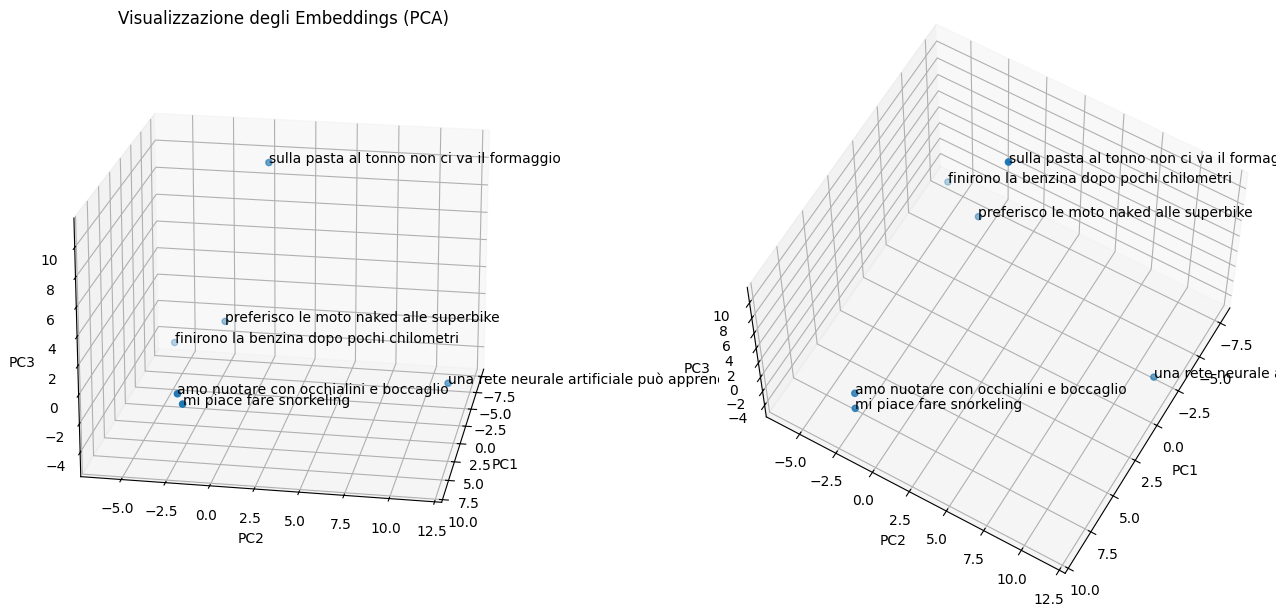

In [16]:
# Esempio di utilizzo

# definizione delle frasi di esempio
sentences = [
    "mi piace fare snorkeling",
    "amo nuotare con occhialini e boccaglio",

    "preferisco le moto naked alle superbike",
    "finirono la benzina dopo pochi chilometri",
    
    "una rete neurale artificiale può apprendere dai dati",
    
    "sulla pasta al tonno non ci va il formaggio",
]


print("Creazione degli embeddings...")
embeddings = create_embeddings(sentences)

print("\nVisualizzazione degli embeddings...")
plot_embeddings(embeddings, sentences, elev=20, azim=10)

In [10]:
# analisi delle similitudini

def find_most_similar(embeddings, sentences, i):
    # Estrai l'embedding della frase i-esima
    target_embedding = embeddings[i]
    
    # Calcola la similarità del coseno tra l'embedding target e tutti gli altri embeddings
    # n.b. `target_embedding` ha dimensione (1xd) mentre `embeddings` ha dimensione (nxd)
    #      quindi avremo un output (1xn) con n numero di vettori in embeddings
    #      per questo motivo prendiamo il primo (unico) elemento di cosine_similarity
    similarities = cosine_similarity([target_embedding], embeddings)[0]
    
    # Trova l'indice della frase più simile
    most_similar_idx = np.argsort(similarities)[-2]  # prendiamo il secondo più alto
                                                     # il primo è la frase stessa
    
    # Restituisci la frase più simile e il valore della similarità
    most_similar_sentence = sentences[most_similar_idx]
    similarity_value = similarities[most_similar_idx]
    
    return most_similar_sentence, similarity_value

print("\nAnalisi delle similitudini:")
for i, sentence in enumerate(sentences):
    most_similar, similarity = find_most_similar(embeddings, sentences, i)
    print(f"\nFrase: '{sentence}'")
    print(f"Frase più simile: '{most_similar}'")
    print(f"Similarità: {similarity:.2f}")


Analisi delle similitudini:

Frase: 'mi piace fare snorkeling'
Frase più simile: 'amo nuotare con occhialini e boccaglio'
Similarità: 0.87

Frase: 'amo nuotare con occhialini e boccaglio'
Frase più simile: 'mi piace fare snorkeling'
Similarità: 0.87

Frase: 'preferisco le moto naked alle superbike'
Frase più simile: 'finirono la benzina dopo pochi chilometri'
Similarità: 0.57

Frase: 'finirono la benzina dopo pochi chilometri'
Frase più simile: 'preferisco le moto naked alle superbike'
Similarità: 0.57

Frase: 'una rete neurale artificiale può apprendere dai dati'
Frase più simile: 'preferisco le moto naked alle superbike'
Similarità: 0.48

Frase: 'sulla pasta al tonno non ci va il formaggio'
Frase più simile: 'preferisco le moto naked alle superbike'
Similarità: 0.53
